In [108]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

In [109]:
# Carga de los datasets
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# Vista general de los datos
print(train_df.head())
print(train_df.info())
print(train_df.describe())


                player         country  height  weight  age            club  \
0  Denis HuseinbaÅ¡iÄ         Germany     184      76   22    1. FC KÃ¶ln    
1          Kim Ju Sung  Korea Republic     186      76   22       FC Seoul    
2        Brais MÃ©ndez           Spain     187      76   26  Real Sociedad    
3         Willi Evseev         Germany     177      73   31      SV Meppen    
4      Slobodan TediÄ          Serbia     191      80   23       Barnsley    

   ball_control  dribbling  marking  slide_tackle  ...  curve  fk_acc  \
0            67         61      NaN            56  ...     44      36   
1            49         42      NaN            57  ...     22      23   
2            82         82      NaN            54  ...     74      75   
3            67         66      NaN            59  ...     63      55   
4            64         60      NaN            17  ...     52      46   

   penalties  volleys  gk_positioning  gk_diving  gk_handling  gk_kicking  \
0        

In [110]:
#Chequear si existen datos faltantes/en blanco
print(train_df.isnull().sum())
print(test_df.isnull().sum())

player               0
country              0
height               0
weight               0
age                  0
club                 0
ball_control         0
dribbling            0
marking           3693
slide_tackle         0
stand_tackle         0
aggression           0
reactions            0
att_position         0
interceptions        0
vision               0
composure            0
crossing             0
short_pass           0
long_pass            0
acceleration         0
stamina              0
strength             0
balance              0
sprint_speed         0
agility              0
jumping              0
heading              0
shot_power           0
finishing            0
long_shots           0
curve                0
fk_acc               0
penalties            0
volleys              0
gk_positioning       0
gk_diving            0
gk_handling          0
gk_kicking           0
gk_reflexes          0
value                0
dtype: int64
player               0
country              

In [111]:
train_df= train_df.drop(columns=['marking'])
test_df = test_df.drop(columns=['marking'])

In [112]:
train_df['value'] = train_df['value'].str.strip()
train_df['value'] = train_df['value'].str.replace(r'\.00$', '.000', regex=True)

df['value'].head(20)

0      1100000
1        23000
2     19500000
3        45000
4        57500
5      2300000
6        77500
7      1800000
8      1500000
9      1600000
10       90000
11     1900000
12     3000000
13       42500
14     1500000
15       16000
16       13000
17       21000
18       23000
19       15000
Name: value, dtype: int64

In [113]:
train_df["value"] = train_df['value'].str.replace('[$]','',regex=True)
train_df['value'] = train_df['value'].str.replace(r'\.', '', regex=True)
train_df['value'] = train_df['value'].astype(int)
train_df['value']

0        1100000
1         230000
2       19500000
3         450000
4         575000
          ...   
3688      190000
3689     1300000
3690      700000
3691    14500000
3692      190000
Name: value, Length: 3693, dtype: int64

In [130]:
from sklearn.preprocessing import OneHotEncoder
categorical_cols = ['player', 'country', 'club']

# Instanciar el codificador
one_hot_encoder = OneHotEncoder(drop='first', sparse=False)

# Transformar las columnas categóricas
encoded_data = one_hot_encoder.fit_transform(train_df[categorical_cols])

# Convertir a un DataFrame
encoded_df = pd.DataFrame(encoded_data, columns=one_hot_encoder.get_feature_names_out(categorical_cols))

# Combinar con el resto del dataset
train_df = pd.concat([train_df.drop(columns=categorical_cols), encoded_df], axis=1)


TypeError: OneHotEncoder.__init__() got an unexpected keyword argument 'sparse'

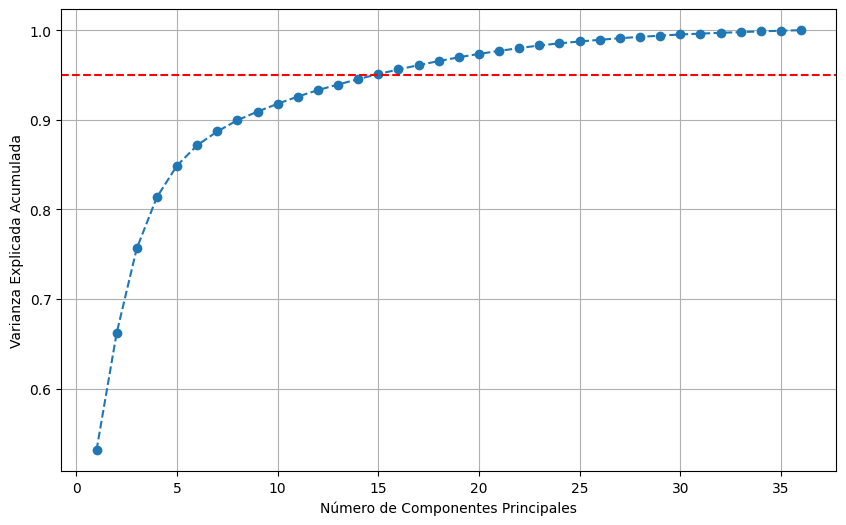

In [114]:
x_test = test_df.drop(columns=['player', 'country', 'club'])
x_train = train_df.drop(columns=['player', 'country', 'club', 'value']) #features
y_train = train_df['value'] #target

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42
)

scaler = StandardScaler()

X_train_split_scaled = scaler.fit_transform(X_train_split)

X_val_split_scaled = scaler.transform(X_val_split)
X_test_scaled = scaler.transform(x_test)


pca = PCA()
X_pca = pca.fit_transform(X_train_split_scaled)


explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)


plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% de varianza explicada')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Explicada Acumulada')
plt.grid()
plt.show()

In [115]:
pca = PCA(n_components=15)
X_pca_train = pca.fit_transform(X_train_split_scaled)
X_pca_val = pca.transform(X_val_split_scaled)
X_pca_test = pca.transform(X_test_scaled)

# Modelos y parámetros para GridSearch
param_grids = {
    "Linear Regression": {
        "model": LinearRegression(),
        "params": {}  # Sin hiperparámetros para ajustar en este caso
    },
    "Ridge": {
        "model": Ridge(),
        "params": {"alpha": [0.1, 1.0, 10.0, 100.0]}
    },
    "Lasso": {
        "model": Lasso(),
        "params": {"alpha": [0.01, 0.1, 1.0, 10.0]}
    },
    "Kernel Ridge": {
        "model": KernelRidge(),
        "params": {
            "alpha": [0.1, 1.0, 10.0],
            "kernel": ["linear", "rbf"],
            "gamma": [0.1, 1.0, 10.0] 
        }
    }
}

results = {}


for name, config in param_grids.items():
    print(f"Buscando mejores hiperparámetros para {name}...")
    grid_search = GridSearchCV(
        config["model"],
        config["params"],
        cv=5,  
        scoring="r2",
        n_jobs=-1
    )
    grid_search.fit(X_pca_train, y_train_split)
    
    best_model = grid_search.best_estimator_
    y_pred_pca = best_model.predict(X_pca_val)
    r2_pca = r2_score(y_val_split, y_pred_pca)
    

    results[name] = {
        "Best Params": grid_search.best_params_,
        "R2 PCA": r2_pca
    }

for model_name, result in results.items():
    print(f"{model_name}:")
    print(f"  Best Params: {result['Best Params']}")
    print(f"  R2 PCA: {result['R2 PCA']}")

Buscando mejores hiperparámetros para Linear Regression...
Buscando mejores hiperparámetros para Ridge...
Buscando mejores hiperparámetros para Lasso...
Buscando mejores hiperparámetros para Kernel Ridge...
Linear Regression:
  Best Params: {}
  R2 PCA: 0.2716496188532712
Ridge:
  Best Params: {'alpha': 100.0}
  R2 PCA: 0.268829515784908
Lasso:
  Best Params: {'alpha': 10.0}
  R2 PCA: 0.27164879416880094
Kernel Ridge:
  Best Params: {'alpha': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
  R2 PCA: 0.7396995516009051


In [118]:
# Obtener el límite superior permitido
max_components = min(X_train_split_scaled.shape[0], X_train_split_scaled.shape[1])

best_r2 = -np.inf
best_n_components = 15

for n_components in range(10, max_components + 1, 5):  # Probar hasta el límite
    pca = PCA(n_components=n_components)
    X_pca_train = pca.fit_transform(X_train_split_scaled)
    X_pca_val = pca.transform(X_val_split_scaled)
    
    # Entrenar el mejor modelo (Kernel Ridge)
    best_model = KernelRidge(alpha=0.1, gamma=0.1, kernel="rbf")
    best_model.fit(X_pca_train, y_train_split)
    y_pred_pca = best_model.predict(X_pca_val)
    r2_pca = r2_score(y_val_split, y_pred_pca)
    
    if r2_pca > best_r2:
        best_r2 = r2_pca
        best_n_components = n_components

print(f"Mejor número de componentes para PCA: {best_n_components}")
print(f"R2 con PCA optimizado: {best_r2}")


Mejor número de componentes para PCA: 10
R2 con PCA optimizado: 0.7613926577289841


In [127]:
# Aplicar el mejor PCA
n_components=10
pca = PCA(n_components)
print(n_components)
X_pca_train = pca.fit_transform(X_train_split_scaled)
X_pca_test = pca.transform(X_test_scaled)

# Entrenar el mejor modelo en todo el conjunto de entrenamiento
best_model = KernelRidge(alpha=0.1, gamma=0.1, kernel="rbf")
best_model.fit(X_pca_train, y_train_split)

# Generar predicciones para el conjunto de prueba
test_predictions = best_model.predict(X_pca_test)

# Guardar en formato submission
submission = pd.DataFrame({
    "ID": test_df.index,
    "value": test_predictions
})
submission.to_csv("submission.csv", index=False)


10
